# NLTK and Child Speech Patterns

I wanted to learn more about Natural Language Processing and applying it to speech development in children. This notebook is my first attempt at findings patterns of children's speech at different ages and possibly predicting the age of a child based on speech patterns.

I found transcripts of children speech corpora at childes.talkbank.org. CHILDES transcripts use the CHAT format and are saved as .cha files.

I chose to only look at the children's speech in this study, so the text is made up of only the child's speech (not the investigator or parent's speech).

## Importing Necessary Libraries 

In [68]:
import os
import glob
from pprint import pprint
import numpy as np
import pandas as pd
pd.set_option('display.width', 2000)
from datetime import time
import re
from collections import Counter
from nltk import word_tokenize, FreqDist, pos_tag
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib


%matplotlib inline

## Import Transcripts From Local .cha Files

In [72]:
path = '/Users/Jackie/nltk_data/corpora/CHILDES/**/*.cha'
files = glob.iglob(path, recursive = True)

speech_list = []
file_list = []

print('Getting files...\n')
for file in files:
    file_list.append(file)
    with open(file) as f:
        speech_list.append(f.read())

print('Found %d files\n' % len(speech_list))
print('An example of a transcript:\n', speech_list[30])

Getting files...

Found 3019 files

An example of a transcript:
 @UTF8
@PID:	11312/c-00015248-1
@Begin
@Languages:	eng
@Participants:	CHI Chuck Target_Child , MOT Mother
@ID:	eng|Bates|CHI|2;4.|male|typical|MC|Target_Child|||
@ID:	eng|Bates|MOT|||||Mother|||
@Bg:	mother_freeplay
*CHI:	right here ?
%mor:	adv|right adv|here ?
%gra:	1|2|JCT 2|0|INCROOT 3|2|PUNCT
%act:	puts nesting cup to top of nesting cup stack . takes cup off
*MOT:	hm: (.) try again .
%mor:	co|hm v|try adv|again .
%gra:	1|2|COM 2|0|ROOT 3|2|JCT 4|2|PUNCT
%gpx:	<1w> shakes head
*MOT:	can you get that out ?
%mor:	mod|can pro:per|you v|get pro:dem|that adv|out ?
%gra:	1|3|AUX 2|3|SUBJ 3|0|ROOT 4|3|OBJ 5|3|JCT 6|3|PUNCT
*CHI:	ye(a)h .
%mor:	co|yeah .
%gra:	1|0|INCROOT 2|1|PUNCT
%act:	<1w> attempts to take top nesting cup out of stack . <1w> picks up another nesting cup . puts down .
*CHI:	xxx .
%act:	<1w> puts another nesting cup in stack <1w> succeeds in removing nesting cup . holds cup .
*MOT:	there you go .
%mor:	adv|the

## Cleaning Up the Transcripts

In [73]:
# Filter list of speeches to grab only those with age of child recorded (label)
# Grab just the child's utterances from the speeches

child_speech_list = []
speech_labels = []

for speech in speech_list:
    label = re.findall(r'\|CHI\|(.*?)\|', speech)
    if len(label) != 0:
        speech_labels.append(str(label))
        child_speech_list.append(re.findall('\*CHI:\t(.*)', speech))
    else:
        speech_labels.append(str(np.NaN))
        child_speech_list.append(str(np.NaN))
    
speech_labels = [re.sub('\[|\]|', '', label) for label in speech_labels] 
speech_labels = [label.replace("'", '') for label in speech_labels]

print('Number of Speeches in Speech List:', len(child_speech_list))
print('Number of Speech Labels:', len(speech_labels))



# If an age was not recorded, drop the speech and the label

child_speech_list = [x for x in child_speech_list if str(x) != 'nan']
speech_labels = [x for x in speech_labels if str(x) != 'nan']

print('\nNew Number of Speeches in Speech List:', len(child_speech_list))
print('New Number of Speech Labels:', len(speech_labels))

Number of Speeches in Speech List: 3019
Number of Speech Labels: 3019

New Number of Speeches in Speech List: 2988
New Number of Speech Labels: 2988


In [74]:
print('An example of a raw speech:\n\n', child_speech_list[30])

# remove the space and period after every utterance
child_speech_list = [[re.sub('\s\.', '', line) for line in speech] 
                     for speech in child_speech_list]

# remove the comments made in square brackets (ie [grunting])
child_speech_list = [[re.sub('\[.*\]', '', line) for line in speech] 
                     for speech in child_speech_list]

# Change "O" to "oh"
child_speech_list = [[re.sub('0', 'oh', line) for line in speech] 
                     for speech in child_speech_list]

# remove symbols within speech (ie .@<[]&+!() )
child_speech_list = [[re.sub(r'[&:@<>().?!+=]', '', line) for line in speech] 
                     for speech in child_speech_list]

# remove inaudible words "xxx" and "yyy" from speech
child_speech_list = [[re.sub('xxx|yyy', '', line) for line in speech] 
                     for speech in child_speech_list]

# remove utterances left empty after removing inaudible
child_speech_list = [[re.sub(r'^\s*$', '', line) for line in speech] 
                     for speech in child_speech_list]

# remove 'laughs' because the child was actually laughing, not saying the word
child_speech_list = [[re.sub(r'laughs', '', line) for line in speech]
                     for speech in child_speech_list]

child_speech_list = [[x for x in speech if x] for speech in child_speech_list]

print('\n\nAn example of a cleaned-up speech:\n\n', child_speech_list[30])

An example of a raw speech:

 ['right here ?', 'ye(a)h .', 'xxx .', 'right here .', '0 .', 'right here ?', 'right here ?', 'oh !', 'yeah !', '0 .', '&-eh !', 'ugh .', 'ugh .', 'right here ?', '&-uh .', '(a)gain .', 'right here .', 'right here .', 'ah !', 'right here ?', '0 .', 'yyy take it all [!] out [!] .', 'yyy .', '(o)kay .', 'okay !', '&-uh and that &-uh now [?] .', 'huh .', 'okay (.) that .', 'here ?', '&-uh yyy heavy .', 'yeah .', 'block !', 'where this block .', 'yyy !', 'yeah .', 'ah !', 'dog .', 'doggie .', 'doggie .', '&-uh doggie .', 'where doggie ?', 'yeah .', 'this go in here .', '0 [=! sighs] .', 'here yyy go .', 'yyy .', 'moink@o .', 'more ball .', 'boink@o !', 'muh_oink@o !', 'boink@o !', 'moick@o !', 'oh in here ?', 'moick@o .', 'moick@o .', '&-uh moink@o .', 'moink@o .', '&-uh .', 'yeah .', 'it went in here .', 'went in here ?', '0 .', '0 .', 'right here ?', 'oh !', '0 .', 'right here .', 'right here ?', 'yyy .', 'I did it .', 'go right here ?']


An example of a cle

## Create the Dataframe and Format 'Age' column (recorded in months)

In [55]:
# Display the age of the child in months

def format_age(label):
    """
    Args:
        label (str or object) - child's age in CHA format (1;11,02)
    Returns:
        age (float) of child in months
    """
    age = 0
    
    years = re.findall('(.*);', label)
    #print(years)
    if len(years) != 0:
        age += float(years[0]) * 12
    else:
        age = np.NaN
    
    months = re.findall(';(.*)\.', label)
    if len(months) != 0:
        age += float(months[0])

    return '{0:g}'.format(float(age))

df = pd.DataFrame()
df['age'] = [format_age(label) for label in speech_labels]
df['speech'] = [x for x in child_speech_list]

print(df.head())
print(df.shape)

  age                                             speech
0  20  [yeah, yeah,  woof, oh, hat, yeah , hey , ahti...
1  20  [oh, that baby , oh, -uh , oh, oh, oh, oh, oh,...
2  20  [ball , ball, ball oh , ball , ball , oh, -uh ...
3  20  [oh, table, oh, oh, oh, oh, oh, oh, oh, oh , n...
4  20  [dog , dog , one , three , gramma , two , gram...
(2988, 2)


## Clean up the dataframe and define our age limits
Drop speeches that do not have an age recorded and drop speeches without any text.
Drop any speeches outside the range of 2 and 6 years old.

In [56]:
df = df[df['age'] != 'nan']
df = df[df.astype(str)['speech'] != '[]']
df.age = df.age.astype(int)
df = df[(df.age <= 72) & (df.age >= 18)]

In [57]:
df.shape

(2870, 2)

## Number of Utterances within a Speech

This feature doesn't tell us much about a child's speech patterns necessarily because it's dependent upon the duration of the recorded session, the amount of prompting the child received, and the speed at which the child talks.

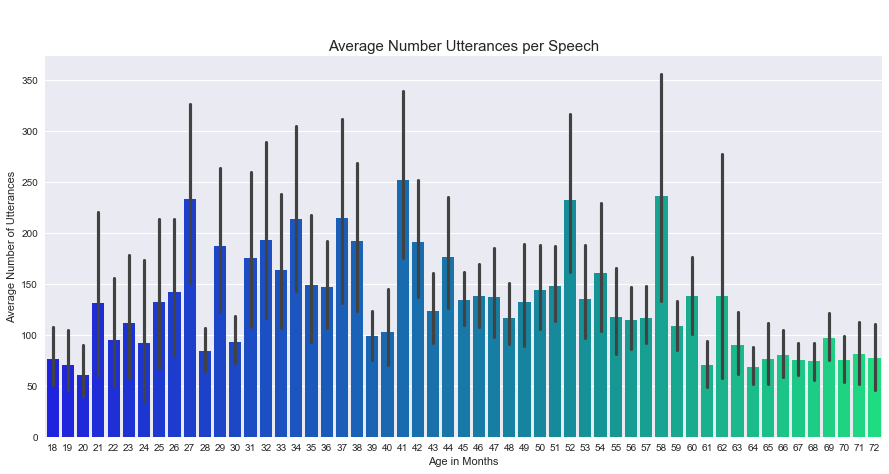

In [58]:
df['utterance_count'] = [len(speech) for speech in df.speech]

fig = plt.figure(figsize=(15, 7))
_ = sns.barplot(x = 'age', y = 'utterance_count', data = df, palette = 'winter')
_ = plt.title('\n\nAverage Number Utterances per Speech', size = 15)
_ = plt.ylabel('Average Number of Utterances')
_ = plt.xlabel('Age in Months')
plt.show()

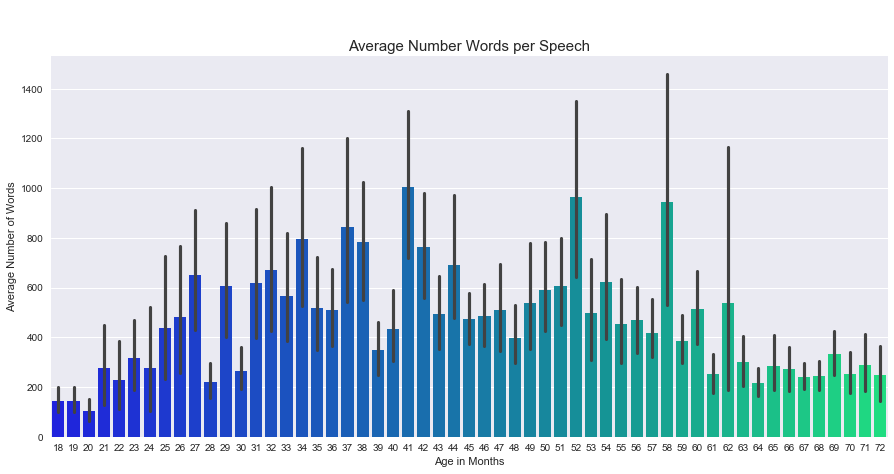

In [59]:
def word_count(speech):
    """
    Args:
        speech (str or list object) - speech corpus
    Returns:
        word count per speech (float)
    """
    
    word_count = []
    
    for line in speech:
        count = len(line.split())
        word_count.append(count)

    return sum(word_count)

df['word_count'] = [word_count(speech) for speech in df.speech]


fig = plt.figure(figsize=(15, 7))
_ = sns.barplot(x = 'age', y = 'word_count', data = df, palette = 'winter')
_ = plt.title('\n\nAverage Number Words per Speech', size = 15)
_ = plt.ylabel('Average Number of Words')
_ = plt.xlabel('Age in Months')
plt.show()

## Unique Word Count

## Average Number of Words Per Utterance

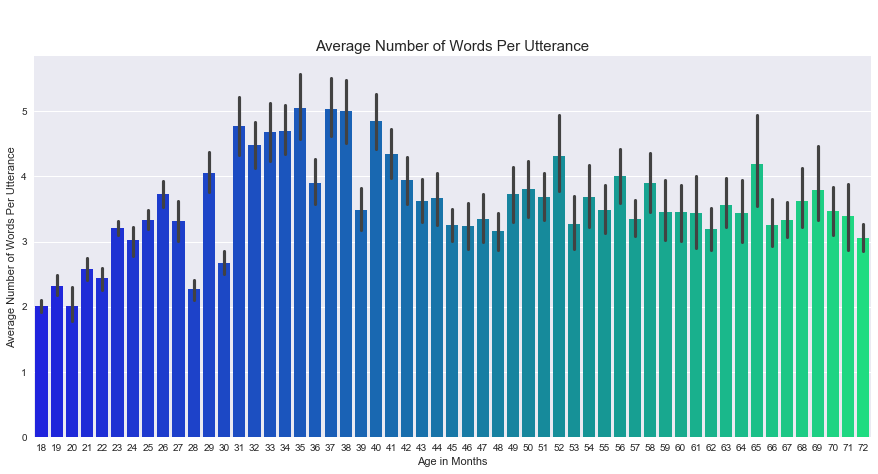

In [60]:
df['avg_word/utterance'] = df['word_count'] / df['utterance_count']


fig = plt.figure(figsize=(15, 7))
_ = sns.barplot(x = 'age', y = 'avg_word/utterance', data = df, palette = 'winter')
_ = plt.title('\n\nAverage Number of Words Per Utterance', size = 15)
_ = plt.xlabel('Age in Months')
_ = plt.ylabel('Average Number of Words Per Utterance')
plt.show()

## Average Length of Words in Speech

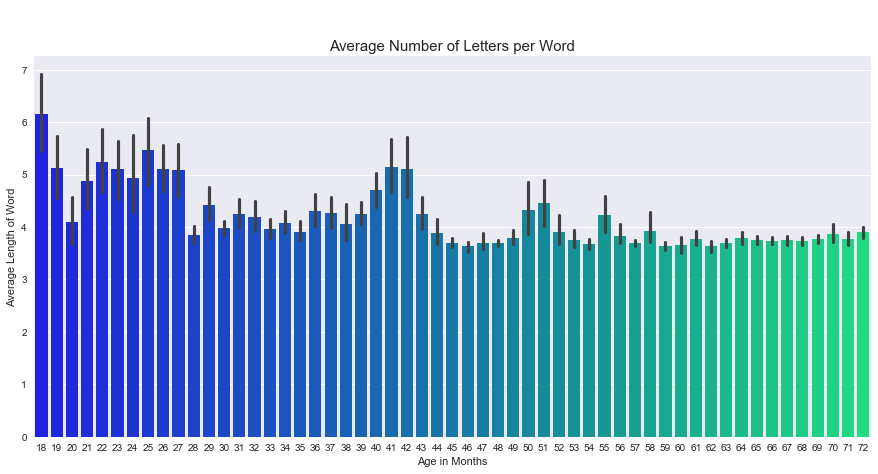

In [61]:
def avg_letters_word(speech):
    """
    Args:
        speech (str or list object) - speech corpus
    Returns:
        average word length speech(float)
    """
    
    letter_count = []
    
    for line in speech:
        words = line.split()
        for word in words:
            letters = list(word)
            num_letters = len(letters)
            letter_count.append(num_letters)
    
    return np.mean(letter_count)

df['avg_letters_word'] = [avg_letters_word(speech) for speech in df.speech]

fig = plt.figure(figsize=(15, 7))
_ = sns.barplot(x = 'age', y = 'avg_letters_word', data = df, palette = 'winter')
_ = plt.title('\n\nAverage Number of Letters per Word', size = 15)
_ = plt.ylabel('Average Length of Word')
_ = plt.xlabel('Age in Months')
plt.show()

In [63]:
df.speech[1]

['oh',
 'that baby ',
 'oh',
 '-uh ',
 'oh',
 'oh',
 'oh',
 'oh',
 'oh',
 'oh',
 'oh',
 'oh',
 'oh',
 'chick ',
 'oh',
 'oh',
 'oh',
 'oh',
 'car ',
 'oh',
 'oh',
 'baby ',
 'oh',
 'oh',
 'oh',
 'oh',
 'oh',
 'm_ap_ap_apo',
 'oh',
 'oh',
 'no',
 'that  ',
 'oh',
 'oh',
 'oh',
 'oh',
 'oh',
 'dog ',
 'dog ',
 'no ',
 'Dad ',
 'oh',
 'oh']

## Words Used Most Frequently

In [64]:
def top_10(speech):
    """
    Args:
        speech (str or list object) - speech corpus
    Returns:
        list of top 10 most frequent words (list)
    """
    
    words_list = []
    for line in speech:
        words = line.split()
        for word in words:
            words_list.append(word)
        
    freq_dist = FreqDist(words_list)
    most_freq = []
    for word in freq_dist.most_common(10):
        most_freq.append(word)
    #print('Most Frequent Words:\n', most_freq, '\n')
    return most_freq


df['top_10_words'] = [top_10(speech) for speech in df.speech]

print(df.loc[:10, ['age','top_10_words']])

# groupby
# wordcloud
# subjects

    age                                       top_10_words
0    20  [(oh, 24), (no, 9), (yeah, 8), (hey, 2), (ah, ...
1    20  [(oh, 31), (that, 2), (baby, 2), (no, 2), (dog...
2    20  [(ball, 31), (oh, 22), (-uh, 10), (where, 9), ...
3    20  [(oh, 15), (no, 3), (cooker, 2), (table, 1), (...
4    20  [(oh, 25), (one, 4), (circle, 3), (dog, 2), (b...
5    20  [(oh, 29), (what's, 5), (that, 5), (-uh, 5), (...
6    22  [(oh, 12), (Mommy, 4), (uhoh, 3), (alright, 2)...
7    20  [(oh, 46), (-uh, 23), (here, 2), (okay, 2), (s...
8    20  [(oh, 30), (my, 3), (chicken, 3), (-um, 2), (t...
9    20         [(oh, 42), (no, 1), (Mommy, 1), (ball, 1)]
10   20  [(oh, 19), (big, 4), (too, 2), (bed, 2), (litt...


## Parts of Speech

In [65]:
# Use NLTK pos_tag to tag parts of speech

def pos_count(row):
    """
    Args:
        speech (str or list object) - speech corpus
    Returns:
        A total percentage for each part of speech used (ie nouns, verbs) (float)
    """
    speech = row['speech']
    
    words_list = []
    for line in speech:
        words = line.split()
        for word in words:
            words_list.append(word)
    
    pos_list = []
    tagged = pos_tag(words_list)
    #print(tagged)
    
    # Initalize POS Count
    nouns = 0
    verbs = 0
    adverbs = 0
    adjectives = 0
    prepositions = 0
    pronouns = 0
    other = 0
    total = 0
    
    # Count POS
    for word, tag in tagged:
        total += 1
        if tag in ['NN', 'NNS', 'NNP', 'NNPS']:
            nouns += 1
        elif tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
            verbs += 1
        elif tag in ['RB', 'RBR', 'RBS', 'RP', 'WRB']:
            adverbs += 1
        elif tag in ['JJ', 'JJR', 'JJS']:
            adjectives += 1
        elif tag in ['IN']:
            prepositions += 1
        elif tag in ['PRP', 'PRP$', 'WP', 'WP$']:
            pronouns += 1
        else:
            other += 1
    
    # Record POS count as a percentage in dataframe
    if total != 0:
        df.loc[index, '%nouns'] = nouns / total * 100
        df.loc[index, '%verbs'] = verbs / total * 100
        df.loc[index, '%adverbs'] = adverbs / total * 100
        df.loc[index, '%adjectives'] = adjectives / total * 100
        df.loc[index, '%prepositions'] = prepositions / total * 100
        df.loc[index, '%pronouns'] = pronouns / total * 100
        df.loc[index, '%other'] = other / total * 100
    else:
        df.loc[index, ['%nouns', '%verbs', '%adverbs', 
                       '%adjectives', '%prepositions', 
                       '%pronouns', '%other']] = 0
        
for index, row in df.iterrows():
    pos_count(row)

df

,age,speech,utterance_count,word_count,avg_word/utterance,avg_letters_word,top_10_words,%nouns,%verbs,%adverbs,%adjectives,%prepositions,%pronouns,%other
0,20,"[yeah, yeah, woof, oh, hat, yeah , hey , ahti...",59,59,1.000000,2.830508,"[(oh, 24), (no, 9), (yeah, 8), (hey, 2), (ah, ...",25.423729,8.474576,5.084746,30.508475,3.389831,1.694915,25.423729
1,20,"[oh, that baby , oh, -uh , oh, oh, oh, oh, oh,...",43,44,1.023256,2.568182,"[(oh, 31), (that, 2), (baby, 2), (no, 2), (dog...",22.727273,15.909091,0.000000,22.727273,0.000000,0.000000,38.636364
2,20,"[ball , ball, ball oh , ball , ball , oh, -uh ...",67,94,1.402985,3.255319,"[(ball, 31), (oh, 22), (-uh, 10), (where, 9), ...",43.617021,15.957447,14.893617,10.638298,5.319149,0.000000,9.574468
3,20,"[oh, table, oh, oh, oh, oh, oh, oh, oh, oh , n...",23,23,1.000000,2.739130,"[(oh, 15), (no, 3), (cooker, 2), (table, 1), (...",30.434783,8.695652,0.000000,30.434783,4.347826,0.000000,26.086957
4,20,"[dog , dog , one , three , gramma , two , gram...",52,53,1.019231,3.150943,"[(oh, 25), (one, 4), (circle, 3), (dog, 2), (b...",41.509434,11.320755,1.886792,20.754717,5.660377,1.886792,16.981132
5,20,"[byebye, oh, oh, oh, oh, oh, oh, oh, oh, oh, o...",58,65,1.120690,3.784615,"[(oh, 29), (what's, 5), (that, 5), (-uh, 5), (...",33.846154,13.846154,3.076923,16.923077,4.615385,0.000000,27.692308
6,22,"[oh, oh, Mommy, Mommy, good Mommy , no Mommy...",29,31,1.068966,3.709677,"[(oh, 12), (Mommy, 4), (uhoh, 3), (alright, 2)...",48.387097,16.129032,0.000000,12.903226,3.225806,0.000000,19.354839
7,20,"[-uh , oh, oh, oh, oh, oh, oh, oh, oh, -uh , o...",84,89,1.059524,2.640449,"[(oh, 46), (-uh, 23), (here, 2), (okay, 2), (s...",32.584270,17.977528,3.370787,25.842697,1.123596,2.247191,16.853933
8,20,"[my chicken, my chicken , my chicken, -um, oh,...",36,41,1.138889,2.512195,"[(oh, 30), (my, 3), (chicken, 3), (-um, 2), (t...",26.829268,14.634146,0.000000,21.951220,0.000000,7.317073,29.268293
9,20,"[oh, oh, oh, oh, no , oh, oh, oh, oh, oh, oh, ...",45,45,1.000000,2.111111,"[(oh, 42), (no, 1), (Mommy, 1), (ball, 1)]",20.000000,11.111111,0.000000,33.333333,2.222222,0.000000,33.333333


In [66]:
# Made a separate dataframe for the parts of speech to make plotting easier

pos_df = df[['age', '%nouns', '%verbs', '%adverbs', '%adjectives',
                       '%prepositions', '%pronouns', '%other']]
pos_df = pos_df.set_index('age')
pos_df.columns = ['Nouns', 'Verbs', 'Adverbs', 'Adjectives', 'Prepositions', 
                  'Pronouns', 'Other']
pos_df = pos_df.sort_index(ascending = True)
pos_df = pos_df.groupby(pos_df.index).mean()
print(pos_df)

         Nouns      Verbs   Adverbs  Adjectives  Prepositions   Pronouns      Other
age                                                                                
18   60.454671  13.785150  5.092687   10.216653      1.759493   3.916790   4.774556
19   53.958507  14.173753  7.213818    9.938058      2.458151   5.891926   6.365788
20   47.702378  13.983612  4.544533   13.757925      3.292963   4.089014  12.629575
21   42.308200  18.135718  6.490423    8.890626      3.282140  13.687898   7.204995
22   39.533490  18.152792  5.586014    9.577419      3.786030  12.238008  11.126246
23   32.745269  23.348706  4.918210    8.012000      3.776005  20.735223   6.464588
24   32.949725  21.760122  6.134744    8.190979      4.425255  19.179335   7.359840
25   32.946466  21.766428  6.194615    8.010328      5.317911  18.608498   7.155755
26   30.297278  22.371017  5.509475    8.279062      6.326354  16.591442  10.625373
27   32.979596  21.103059  7.371636    8.244231      5.799645  14.399762  10

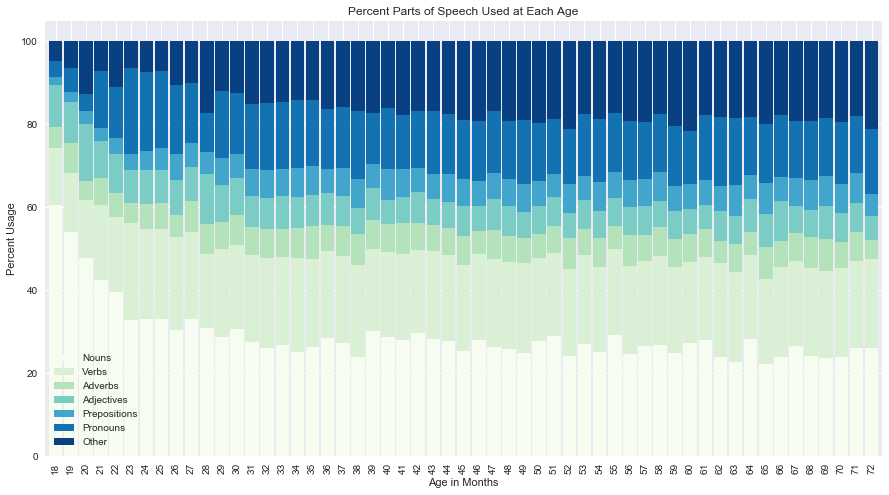

In [67]:
# Plot parts of speech versus age

ax = pos_df.plot.bar(figsize = [15, 8], colormap = 'GnBu', stacked = True, width = 0.9,
                     title = 'Percent Parts of Speech Used at Each Age')
_ = ax.set_xlabel('Age in Months')
_ = ax.set_ylabel('Percent Usage')